In [1]:
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Clustering
from sklearn.cluster import KMeans

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load and understand the data

In [2]:
DATA = "data/crash_data.csv"
# Load the dataset
data = pd.read_csv(DATA)

# Display the first few rows
data.head()

,OBJECTID,Document_Nbr,Crash_Year,Crash_Severity,Driver_VehicleNumber,Driver_InjuryType,Driver_Age,Driver_Gender,Driver_Action_Type_Cd,Driver_Airbag_Deployment,...,Ped_Action,Ped_Drink,Ped_Cond,Ped_Al_Test,Ped_Drug,Ped_Rflct,Numberoflane,Carspeedlimit,Local Case CD,Route or Street Name
0,1,100200959,2009,B,1,PDO,48,Male,1. No Improper Action,2. Not Deployed,...,1. Crossing At Intersection With Signal,1. No Drinking,1. No Defects,4. No Test,3. Unknown,2. No,4.0,35.0,20093440243,RT 7LEESBURG PIKE
1,2,93010657,2009,O,1;2,PDO;PDO,45;57,Male;Male,22. Disregarded Stop or Yield Sign;1. No Impro...,2. Not Deployed;2. Not Deployed,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,R-2385,WARWICK BLVD
2,3,92440184,2009,O,1;2,NA;PDO,47,Male;Male,34. Hit and Run;1. No Improper Action,2. Not Deployed;2. Not Deployed,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,P09040800226,1800 BLK E BRAMBELTON
3,4,92870200,2009,O,1,PDO,17,Female,1. No Improper Action,2. Not Deployed,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,55.0,NaN,I 66 EAST
4,5,93400162,2009,C,1;2,C;PDO,53;63,Female;Male,11. Did Not Have Right-of-Way;1. No Improper A...,1. Deployed - Front;3. n/a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200909150302,DISTRIBUTOR DRIVE


In [3]:
data.info()

# Print out the columns that arent objects
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844692 entries, 0 to 844691
Data columns (total 65 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   OBJECTID                     844692 non-null  int64  
 1   Document_Nbr                 844692 non-null  int64  
 2   Crash_Year                   844692 non-null  int64  
 3   Crash_Severity               844692 non-null  object 
 4   Driver_VehicleNumber         844692 non-null  object 
 5   Driver_InjuryType            840732 non-null  object 
 6   Driver_Age                   829887 non-null  object 
 7   Driver_Gender                844692 non-null  object 
 8   Driver_Action_Type_Cd        844692 non-null  object 
 9   Driver_Airbag_Deployment     844692 non-null  object 
 10  Driver_Alcohol_Test_Type_Cd  844692 non-null  object 
 11  Driver_Condition_Type_Cd     844692 non-null  object 
 12  Driver_Distraction_Type_Cd   844692 non-null  object 
 13 

,OBJECTID,Document_Nbr,Crash_Year,Numberoflane,Carspeedlimit
count,844692.000000,8.446920e+05,844692.000000,630024.000000,373565.000000
mean,422346.500000,1.232730e+08,2012.042972,3.214603,48.608248
std,243841.721129,1.946874e+07,1.997255,1.374737,11.252441
min,1.000000,9.013510e+07,2009.000000,0.000000,15.000000
25%,211173.750000,1.036403e+08,2010.000000,2.000000,40.000000
50%,422346.500000,1.222652e+08,2012.000000,3.000000,45.000000
75%,633519.250000,1.413050e+08,2014.000000,4.000000,55.000000
max,844692.000000,1.605500e+08,2015.000000,10.000000,70.000000


In [4]:
# Columns and number of missing values from high to low
print(f"Number of missing values (high to low): \n {data.isnull().sum().sort_values(ascending=False)}")

# Drop columsn with more than 90% missing values
data = data.dropna(thresh=0.7*data.shape[0], axis=1)

print(f"Number of missing values after the drop (high to low): \n {data.isnull().sum().sort_values(ascending=False)}")
print(f"Number of columns: {len(data.columns)}")

Number of missing values (high to low): 
 Bike_Age                      839787
Bike_InjuryType               839707
Bike_VehicleNumber            839684
Bike_Gender                   839684
PED_Age                       833367
                               ...  
Fourth_Crash_Event_Cd              0
Direction_Of_Travel_Cd             0
Initial_Veh_Impact_Area_Cd         0
Second_Crash_Event_Cd              0
Third_Crash_Event_Cd               0
Length: 65, dtype: int64
Number of missing values after the drop (high to low): 
 Numberoflane                   214668
Local Case CD                  175653
Route or Street Name           129771
Driver_Age                      14805
Vehicle_Model_Nm                11801
Speed_Before                     7707
Vehicle_Year_Nbr                 4312
Driver_InjuryType                3960
Vehicle_Make_Nm                  2310
Speed_Max_Safe                   2145
Speed_Posted                     1266
Driver_Action_Type_Cd               0
Driver_Gender

## Encode categorical data

In [5]:
# Encode categorical values
def split_string(string):
    # If the string is empty or nan, return an empty list
    if string == "" or pd.isnull(string):
        return []
    # Break down each string into a list if there is a semicolon
    if ";" in str(string):
        parts = string.split(";")                
        return parts
    else:
        return [string]
    
def find_id(string):
    string = str(string).strip()
    result = ""
    for char in string:
        if char.isdigit():
            result += char
        elif char == ".":
            return result
        else:
            break
    return None

def clean_values(string):
    individual_strings: list = split_string(string)
    output: list = []
    for string in individual_strings:
        if find_id(string):
            output.append(find_id(string))
        else:
            output.append(string)
    return output

# Apply clean_values to all of the categorical columns
for column in data.columns:
    if data[column].dtype == "object":
        data[column] = data[column].apply(clean_values)

In [9]:
# Flatten the lists
for column in data.columns:
    if data[column].dtype == "object":
        data[column] = data[column].apply(lambda x: x if type(x) != list else x[0] if len(x) > 0 else None)

data.head()

,OBJECTID,Document_Nbr,Crash_Year,Crash_Severity,Driver_VehicleNumber,Driver_InjuryType,Driver_Age,Driver_Gender,Driver_Action_Type_Cd,Driver_Airbag_Deployment,...,First_Crash_Event_Cd,Second_Crash_Event_Cd,Third_Crash_Event_Cd,Fourth_Crash_Event_Cd,Most_Harmful_Crash_Event_Cd,Initial_Veh_Impact_Area_Cd,Direction_Of_Travel_Cd,Numberoflane,Local Case CD,Route or Street Name
0,1,100200959,2009,B,1,PDO,48,Male,1,2,...,19,n/a,n/a,n/a,19,0,n/a,4.000000,20093440243,RT 7LEESBURG PIKE
1,2,93010657,2009,O,1,PDO,45,Male,22,2,...,20,n/a,n/a,n/a,20,12,North,4.000000,R-2385,WARWICK BLVD
2,3,92440184,2009,O,1,NA,47,Male,34,2,...,20,n/a,n/a,n/a,20,12,West,4.000000,P09040800226,1800 BLK E BRAMBELTON
3,4,92870200,2009,O,1,PDO,17,Female,1,2,...,23,n/a,n/a,n/a,23,12,East,2.000000,None,I 66 EAST
4,5,93400162,2009,C,1,C,53,Female,11,1,...,20,n/a,n/a,n/a,20,12,West,3.214603,200909150302,DISTRIBUTOR DRIVE


In [10]:
# One hot encode
# Identify categorical variables
categorical_vars = data.select_dtypes(include=['object']).columns.tolist()
print("Categorical variables:")
print(categorical_vars)

# Initialize the encoder
encoder = OrdinalEncoder()

# Encode categorical variables
data[categorical_vars] = data[categorical_vars].fillna('Missing')
data[categorical_vars] = encoder.fit_transform(data[categorical_vars])# Encode categorical values

Categorical variables:
['Crash_Severity', 'Driver_VehicleNumber', 'Driver_InjuryType', 'Driver_Age', 'Driver_Gender', 'Driver_Action_Type_Cd', 'Driver_Airbag_Deployment', 'Driver_Alcohol_Test_Type_Cd', 'Driver_Condition_Type_Cd', 'Driver_Distraction_Type_Cd', 'Driver_Drinking_Type_Cd', 'Driver_Drug_Use_Cd', 'Driver_Ejected_From_Vehicle', 'Driver_Ems_Transport_Ind', 'Driver_Fled_Scene_Ind', 'Driver_Safety_Equip_Used', 'Driver_Vis_Obscured_Type_Cd', 'Summons_Issued_Cd', 'Vehiclenumber', 'Vehicle_Body_Type_Cd', 'Vehicle_Make_Nm', 'Vehicle_Maneuver_Type_Cd', 'Vehicle_Model_Nm', 'Vehicle_Year_Nbr', 'Comm_Cargo_Body_Type_Cd', 'Comm_Vehicle_Body_Type_Cd', 'Speed_Before', 'Speed_Posted', 'Speed_Max_Safe', 'First_Crash_Event_Cd', 'Second_Crash_Event_Cd', 'Third_Crash_Event_Cd', 'Fourth_Crash_Event_Cd', 'Most_Harmful_Crash_Event_Cd', 'Initial_Veh_Impact_Area_Cd', 'Direction_Of_Travel_Cd', 'Local Case CD', 'Route or Street Name']


## Look into data correlation now that most of the data is cleaned

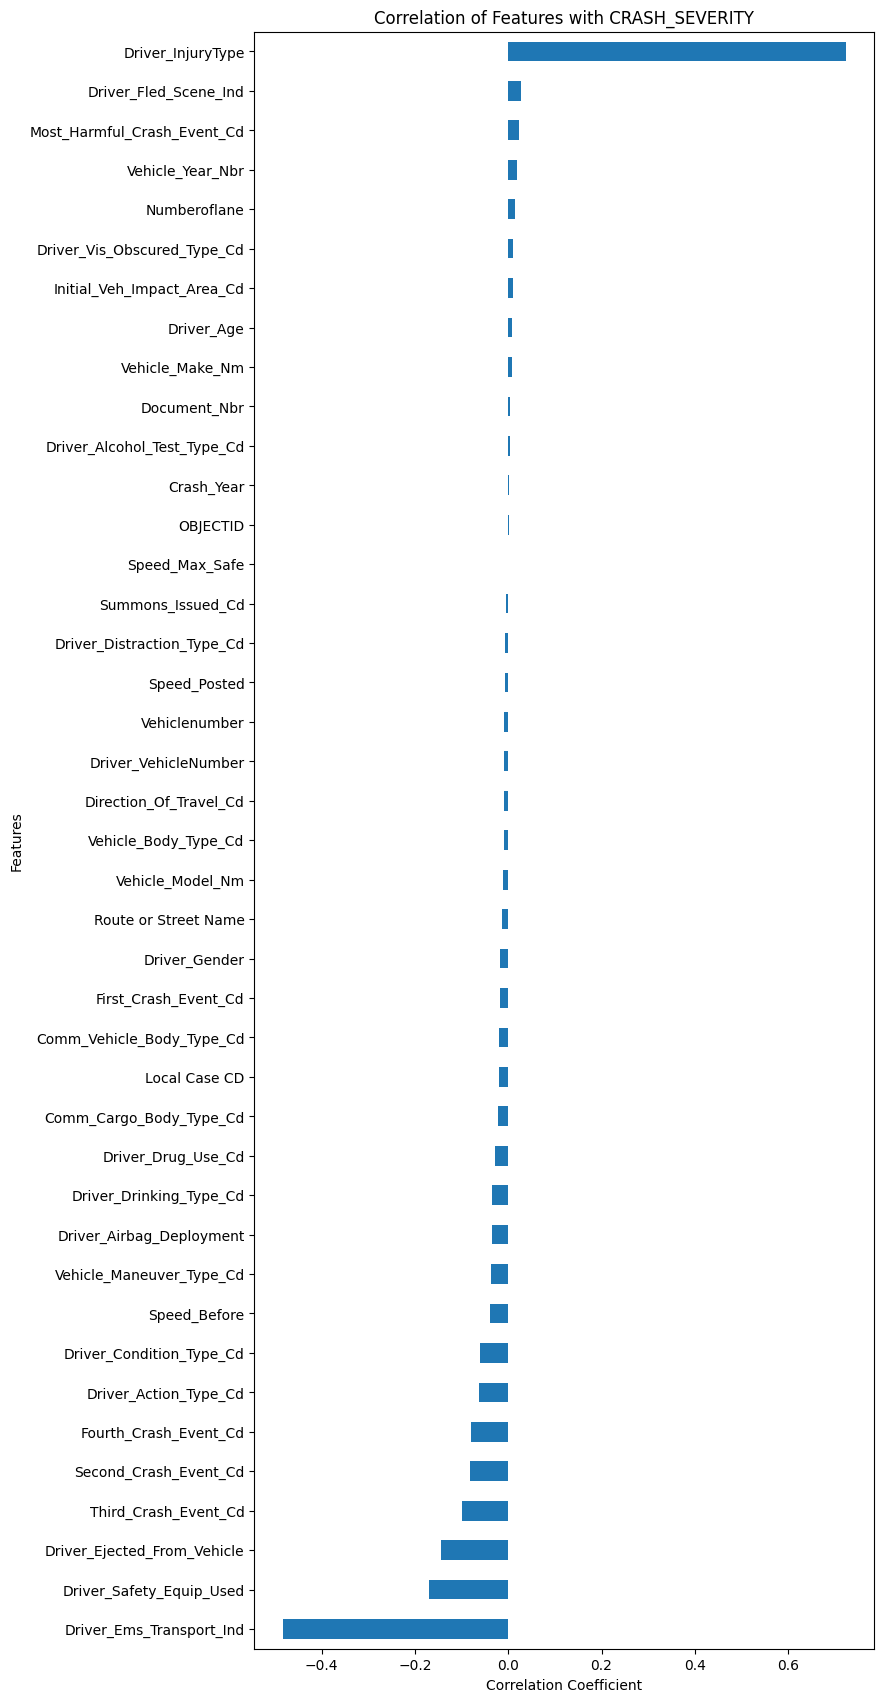

In [11]:
# Drop rows with missing 'CRASH_SEVERITY'
data = data.dropna(subset=['Crash_Severity'])

# Identify numerical and categorical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# # Fill missing values
for col in numerical_cols:
    data[col] = data[col].fillna(data[col].mean())
for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# One-Hot Encode categorical variables
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Compute the correlation matrix
corr_matrix = data_encoded.corr()

# Get correlations with 'CRASH_SEVERITY'
crash_severity_corr = corr_matrix['Crash_Severity'].sort_values(ascending=False)

# Visualize correlations with 'CRASH_SEVERITY'
plt.figure(figsize=(8, len(crash_severity_corr) / 2))
crash_severity_corr.drop('Crash_Severity').plot(kind='barh')
plt.title('Correlation of Features with CRASH_SEVERITY')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()

In [15]:
# Print out the list where the correlation coefficient is greater than abs(0.2)
print(crash_severity_corr[abs(crash_severity_corr) > 0.1])
# List of the features with a correlation coefficient greater than abs(0.1)
selected_features = crash_severity_corr[abs(crash_severity_corr) > 0.1].index.tolist()

Crash_Severity                 1.000000
Driver_InjuryType              0.724765
Driver_Ejected_From_Vehicle   -0.143726
Driver_Safety_Equip_Used      -0.169650
Driver_Ems_Transport_Ind      -0.484064
Name: Crash_Severity, dtype: float64


# Basic Training Experiments

In [16]:
# Define target variable and features
target = 'Crash_Severity'  # Adjust to match the exact column name in your dataset

# Create the feature matrix X and target vector y
X = data[selected_features]
y = data[target]

In [17]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")

Model Performance:
RMSE: 0.0
R^2 Score: 1.0


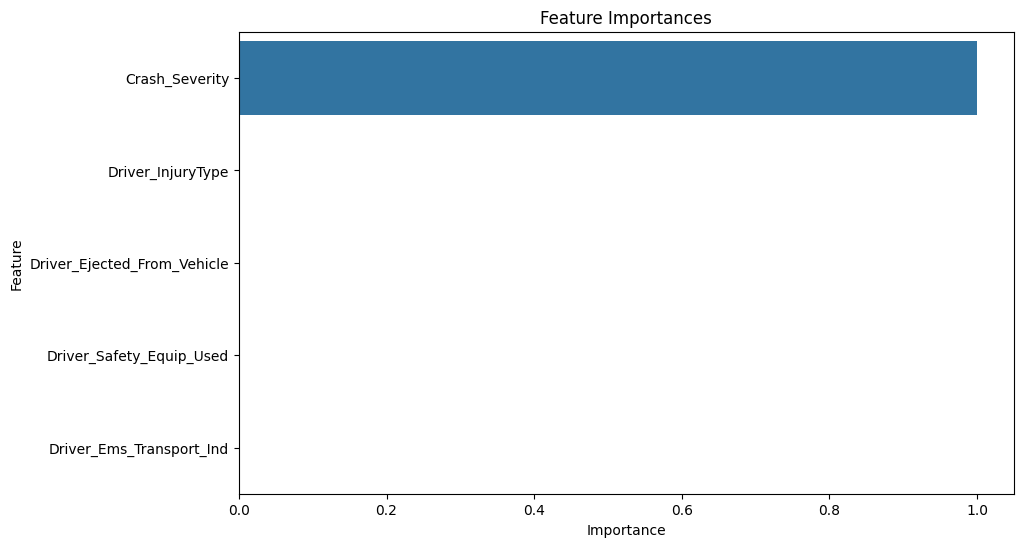

In [20]:
# Get feature importances
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=selected_features).sort_values(ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

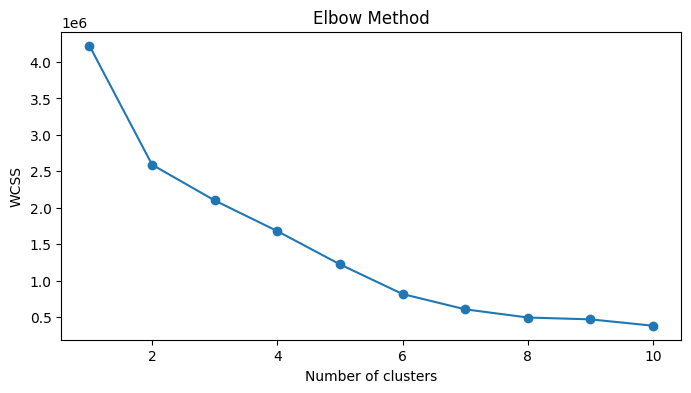

In [21]:
# Standardize the features
scaler = StandardScaler()
X_cluster = scaler.fit_transform(data[selected_features])

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_cluster)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()


In [22]:
# Fit K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_cluster)

# Add the cluster labels to the original data
data['Cluster'] = clusters

In [27]:
# Analyze the characteristics of each cluster
cluster_summary = data.groupby('Cluster')[selected_features].mean()
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
         Crash_Severity  Driver_InjuryType  Driver_Ejected_From_Vehicle  \
Cluster                                                                   
0              3.452358           5.813664                     0.969425   
1              0.955114           1.153377                     1.120487   

         Driver_Safety_Equip_Used  Driver_Ems_Transport_Ind  
Cluster                                                      
0                        2.985708                  0.108885  
1                        3.675274                  1.422545  
